In [93]:
import numpy as np
import pandas as pd
import json
import requests
import re
import bs4
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt

# Web Scraping from Allrecipes

In order to compile a dataset of recipes for this project, we will first need to use web scraping and build a JSON object.  For this, we will send requests to www.allrecipes.com and parse their recipe cards.

In [78]:
# set how many pages to scrape recipes from
first_page = 1
last_page = 50

In [79]:
# create empty json file to store recipe data
data = []
with open('recipes.json','w') as out_file:
    json.dump(data, out_file, indent=4)

In [80]:
def save_to_json(title, layout, picture, servings, ingredients, method, prep_time, cook_time, additional_time, total_time):
    with open('recipes.json') as in_file:
        data = json.load(in_file)
    
    # if this recipe title already exists in the data, do not add it again
    already_exists = False
    for recipe in data:
        if recipe['title'] == title:
            already_exists = True
    
    # if a new recipe, append to the json object and dump back to the file
    if not already_exists:
        print("Saved: {} ".format(title))
        new_recipe = {}
        new_recipe['title'] = title
        new_recipe['layout'] = layout
        new_recipe['picture'] = picture
        new_recipe['ingredients'] = ingredients
        new_recipe['method'] = method
        new_recipe['servings'] = servings
        new_recipe['prep_time'] = prep_time
        new_recipe['cook_time'] = cook_time
        new_recipe['additional_time'] = additional_time
        new_recipe['total_time'] = total_time

        data.append(new_recipe)
    
        with open('recipes.json', 'w') as out_file:
            json.dump(data, out_file, indent=4)
    else:
        print("Already Exists: {} ".format(title))

Note that allrecipes has two different HTML layouts for their recipe pages, a regular layout and a layout which supports shopping for ingredients directly from the recipe page.  These two layouts have the information we need in different locations, so we need to differentiate them.  If the title element we initially search for is set to 'None', we have to instead look for the elements where they would be in the second (shopper) layout.

In [82]:
for page in range(first_page, last_page + 1):
    # request the main allrecipes page which lists the top recipes
    source = requests.get("https://www.allrecipes.com/recipes?page=" + str(page))
    print("PARSING PAGE {}".format(page))
    doc = bs(source.text,'html.parser')
    
    # find each recipe linked on the main page, and open their links one by one
    recipe_cards = doc.select('a.fixed-recipe-card__title-link')

    for card in recipe_cards:
        # these are the values we will scrape for.  We first declare them as empty strings and lists
        layout = 0
        ingredients_list = []
        method_list = []
        title, picture = '', ''
        prep_time, cook_time, total_time, additional_time, servings, = '','','','',''
        
        #open the page for each recipe card and parse its html
        recipe_page_source = requests.get(card['href'])        
        recipe_main = bs(recipe_page_source.text,'html.parser')
        
        # search for the values we declared above
        title = recipe_main.select_one('.recipe-summary__h1')
        if title is not None:
            #for ordinary formatting layout (1)
            layout = 1
            title = title.text
            picture = recipe_main.select_one('.rec-photo').attrs['src']
            ingredients = recipe_main.select('.recipe-ingred_txt')
            method = recipe_main.select('.recipe-directions__list--item')
            servings = recipe_main.select_one('#metaRecipeServings')['content']
            
            meta_item_types = recipe_main.select('.prepTime__item--type')
            meta_item_times = recipe_main.select('.prepTime__item--time')
            
            for label, time in zip(meta_item_types, meta_item_times):
                if label.text == 'Prep':
                    prep_time = time.text
                elif label.text =='Cook':
                    cook_time = time.text
                elif label.text == 'Additional':
                    additional_time = time.text
                elif label.text == 'Ready In':
                    total_time = time.text                
                
        # if the title is 'None', then the page must be in the shopper formatting layout
        else:
            # for shopper formatting layout (2)
            layout = 2
            title = recipe_main.select_one('h1.headline.heading-content').text
            picture = recipe_main.select_one('.inner-container > img').attrs['src']
            ingredients = recipe_main.select('span.ingredients-item-name')
            method = recipe_main.select('div.paragraph > p')
            meta_items = recipe_main.select('div.recipe-meta-item')

            for item in meta_items:
                parts = item.select('div')
                header = parts[0].text.strip()
                body = parts[1].text.strip()
                    
                if header == 'prep:':
                    prep_time = body
                elif header =='cook:':
                    cook_time = body
                elif header == 'additional:':
                    additional_time = body
                elif header == 'total:':
                    total_time = body
                elif header == 'Servings:':
                    servings = body
        
        # compile a list of ingredients for the current recipe
        for ingredient in ingredients:
            if ingredient.text != 'Add all ingredients to list' and ingredient.text != '':
                ingredients_list.append(ingredient.text.strip())
            
        # compile a list of method instructions for the current recipe
        for instruction in method:
            method_list.append(instruction.text.strip())
        
        # add this to the json string being built by our custom JsonBuilder class
        save_to_json(title, 
                    layout, 
                    picture, 
                    servings, 
                    ingredients_list, 
                    method_list, 
                    prep_time, 
                    cook_time, 
                    additional_time, 
                    total_time
                   )
        
print("FINISHED PARSING")

PARSING PAGE 1
Saved: Greek Chicken Skewers 
Saved: World's Best Lasagna 
Saved: Best Chocolate Chip Cookies 
Saved: Fluffy Pancakes 
Saved: Good Old Fashioned Pancakes 
Saved: Banana Banana Bread 
Saved: Apple Pie by Grandma Ople 
Saved: Delicious Ham and Potato Soup 
Saved: Banana Crumb Muffins 
Saved: To Die For Blueberry Muffins 
Saved: Best Brownies 
Saved: Chicken Pot Pie IX 
Saved: Best Big, Fat, Chewy Chocolate Chip Cookie 
Saved: Award Winning Soft Chocolate Chip Cookies 
Saved: The Best Rolled Sugar Cookies 
Saved: Broiled Tilapia Parmesan 
Saved: Mom's Zucchini Bread 
Saved: Downeast Maine Pumpkin Bread 
Saved: Awesome Slow Cooker Pot Roast 
Saved: Slow Cooker Chicken and Dumplings 
Saved: Janet's Rich Banana Bread 
PARSING PAGE 2
Saved: Brown Sugar Meatloaf 
Saved: Baked Ziti I 
Saved: Easy Meatloaf 
Saved: Clone of a Cinnabon 
Saved: Boilermaker Tailgate Chili 
Saved: Apple Crisp II 
Saved: Easy Sugar Cookies 
Saved: Baked Teriyaki Chicken 
Saved: Taco Seasoning I 
Saved: 

Saved: Italian Breaded Pork Chops 
Saved: Simple Whole Wheat Bread 
Saved: Chicken Fried Chicken 
Saved: Caramel Apple Pork Chops 
Saved: Catherine's Spicy Chicken Soup 
Saved: Flatlander Chili 
Saved: Aunt Teen's Creamy Chocolate Fudge 
Saved: Butternut Squash Soup II 
Saved: Easiest Peanut Butter Fudge 
Saved: Unbelievable Chicken 
Saved: Cha Cha's White Chicken Chili 
Saved: No Bake Cookies III 
Saved: Chicken Tortilla Soup V 
Saved: Turkey and Quinoa Meatloaf 
Saved: Red Skinned Potato Salad 
Saved: Creamy Chocolate Frosting 
PARSING PAGE 14
Saved: My Best Clam Chowder 
Saved: Ninety Minute Cinnamon Rolls 
Saved: Honey Baked Chicken II 
Saved: Marie's Easy Slow Cooker Pot Roast 
Saved: Chocolate Crinkles II 
Saved: Caramel Popcorn 
Saved: Garlic Prime Rib 
Saved: Slow Cooker Taco Soup 
Saved: Lemon Garlic Tilapia 
Saved: Cake Balls 
Saved: High Temperature Eye-of-Round Roast 
Saved: Greek Baklava 
Saved: Spinach Tomato Tortellini 
Saved: Chicken Noodle Casserole I 
Saved: Oatmeal R

Saved: Connie's Zucchini "Crab" Cakes 
Saved: Cream Cheese Squares 
Saved: Easy Key Lime Pie I 
Saved: Buttercream Icing 
Saved: The Best Thai Coconut Soup 
Saved: Bacon Cheddar Deviled Eggs 
Saved: Robbi's M&Ms® Cookies 
Saved: Quick Chicken Piccata 
Saved: Banana Oat Muffins 
PARSING PAGE 26
Saved: Russian Tea Cakes I 
Saved: Absolutely the Best Chocolate Chip Cookies 
Saved: Paul's Pumpkin Bars 
Saved: Eileen's Spicy Gingerbread Men 
Saved: Ranch Dressing II 
Saved: Baked Buffalo Wings 
Saved: Chocolate Cupcakes 
Saved: Bacon Ranch Pasta Salad 
Saved: Baked Salmon Fillets Dijon 
Saved: Ten Minute Enchilada Sauce 
Saved: Herb Roasted Pork 
Saved: Rich and Creamy Tomato Basil Soup 
Saved: Incredibly Cheesy Turkey Meatloaf 
Saved: Barbecued Beef 
Saved: Japanese Chicken Wings 
Saved: Winter Fruit Salad with Lemon Poppyseed Dressing 
Saved: Quick Quiche 
Saved: Fresh Broccoli Salad 
Saved: Pizza Dough III 
Saved: Filet Mignon with Rich Balsamic Glaze 
PARSING PAGE 27
Saved: Creamy Hot C

Saved: Oven Fried Chicken III 
Saved: Chicken Quesadillas 
Saved: Vegan Brownies 
Saved: Spanish Flan  
Saved: Best Ever Muffins 
PARSING PAGE 38
Saved: Fried Cabbage with Bacon, Onion, and Garlic 
Saved: Apple Crumble Pie 
Saved: Restaurant Style Beef and Broccoli 
Saved: Grandma VanDoren's White Bread 
Saved: Mexican Rice III 
Saved: B and L's Strawberry Smoothie 
Saved: Molasses Sugar Cookies 
Saved: Whipped Cream 
Saved: Mom's Buttermilk Pancakes 
Saved: Simple Hamburger Stroganoff 
Saved: Lemon Square Bars 
Saved: Chicken Scampi II 
Saved: Blackened Salmon Fillets 
Saved: Emily's Famous Hash Browns 
Saved: Golden Potato Soup 
Saved: Creamy White Chili 
Saved: Shoyu Chicken 
Saved: Shrimp and Mushroom Linguini with Creamy Cheese Herb Sauce 
Saved: Grandma's Gingersnap Cookies 
Saved: Marinated Tuna Steak 
PARSING PAGE 39
Saved: Chicken and Bacon Shish Kabobs 
Saved: Easy Morning Glory Muffins 
Saved: Sweet and Sour Pork III 
Saved: Strawberry Muffins 
Saved: Grilled Fish Tacos with

Saved: Vegan Chocolate Cake 
Saved: Apple Butter Pork Loin 
Saved: Restaurant-Style Hashbrown Casserole 
Saved: Best of the Best Blueberry Muffins 
Saved: Baked Lemon Chicken with Mushroom Sauce 
Saved: Pesto Cheesy Chicken Rolls 
Saved: Buckeye Balls II 
Saved: Sarge's EZ Pulled Pork BBQ 
Saved: Egg and Sausage Casserole 
Saved: Sauteed Garlic Asparagus 
Saved: Oven Pot Roast 
Saved: Broccoli Chicken Casserole I 
Saved: Fried Cabbage II 
Saved: Grilled Tilapia with Mango Salsa 
FINISHED PARSING


# Data Analysis

Now we have a JSON object which contains recipe information scraped from the web.  We can use this data and perform some analyses on it.

In [177]:
#load json object into dataframe
recipes = pd.read_json(r'recipes.json')

# re-order columns
recipes = recipes[['title', 'servings', 'cook_time', 'prep_time', 'additional_time', 
                   'total_time', 'ingredients', 'method', 'layout', 'picture']]
recipes.head()

,title,servings,cook_time,prep_time,additional_time,total_time,ingredients,method,layout,picture
0,Greek Chicken Skewers,4,20 mins,20 mins,2 hrs,2 hrs 40 mins,"[¼ cup lemon juice, ¼ cup wok oil, ⅛ cup red w...","[Whisk lemon juice, oil, vinegar, onion flakes...",2,https://imagesvc.meredithcorp.io/v3/mm/image?u...
1,World's Best Lasagna,12,2 hrs 30 mins,30 mins,15 mins,3 hrs 15 mins,"[1 pound sweet Italian sausage, ¾ pound lean g...","[In a Dutch oven, cook sausage, ground beef, o...",2,https://imagesvc.meredithcorp.io/v3/mm/image?u...
2,Best Chocolate Chip Cookies,24,10 mins,20 mins,30 mins,1 hr,"[1 cup butter, softened, 1 cup white sugar, 1 ...",[Preheat oven to 350 degrees F (175 degrees C)...,2,https://imagesvc.meredithcorp.io/v3/mm/image?u...
3,Fluffy Pancakes,4,10,10,,25,"[3/4 cup milk, 2 tablespoons white vinegar, 1 ...",[Combine milk with vinegar in a medium bowl an...,1,https://images.media-allrecipes.com/userphotos...
4,Good Old Fashioned Pancakes,8,15,5,,20,"[1 1/2 cups all-purpose flour, 3 1/2 teaspoons...","[In a large bowl, sift together the flour, bak...",1,https://images.media-allrecipes.com/userphotos...


### Analyzing Ingredients

Let's look at the ingredients that compose each recipe a bit more closely.  First, we want to know what the most common ingredients are among our scraped recipes.

In [132]:
all_ingredients_list = []

for row in recipes['ingredients']:
    for ing in row:
        all_ingredients_list.append(ing)

In [133]:
ingredients = pd.DataFrame(all_ingredients_list, columns=['ingredients'])
ingredients['edited'] = ingredients['ingredients']
ingredients.head()

,ingredients,edited
0,¼ cup lemon juice,¼ cup lemon juice
1,¼ cup wok oil,¼ cup wok oil
2,⅛ cup red wine vinegar,⅛ cup red wine vinegar
3,1 tablespoon onion flakes,1 tablespoon onion flakes
4,1 tablespoon minced garlic,1 tablespoon minced garlic


Now we attempt to clean the ingredients list to get rid of the 'noise' and have a raw list of ingredient names without units, numbers or descriptors.

In [134]:
# lists of common words we want to remove
units = ['gallon','quart','pint','cup','teaspoon','tablespoon','ounce','pound','can','pinch','serving','slice','package','bottle']
descriptors = ['small','medium','large']

# remove common measuring and descriptive words
for word in units + descriptors:
    plural = word+"s"
    ingredients['edited'] = ingredients['edited'].str.replace(' '+plural+' ', ' ')
    ingredients['edited'] = ingredients['edited'].str.replace(' '+word+' ','')

#remove common leading descriptors
ingredients['edited'] = ingredients['edited'].str.replace('boneless,','')
ingredients['edited'] = ingredients['edited'].str.replace('skinless,','')
ingredients['edited'] = ingredients['edited'].str.replace('boneless','')
ingredients['edited'] = ingredients['edited'].str.replace('skinless','')
    
# remove parantheicals
ingredients['edited'] = ingredients['edited'].str.replace(r'\([^()]*\)','')
# remove text after commas and hyphens
ingredients['edited'] = ingredients['edited'].str.partition(',')
ingredients['edited'] = ingredients['edited'].str.partition(',')
# remove non-alphabetical characters
ingredients['edited'] = ingredients['edited'].str.replace('[^a-zA-Z]', ' ')

# edit down extra spaces caused by adjacent removals
ingredients['edited'] = ingredients['edited'].str.strip()

#fix other miscellaneous common errors
ingredients['edited'] = ingredients['edited'].str.replace('eggs','egg')

ingredients.head()

,ingredients,edited
0,¼ cup lemon juice,lemon juice
1,¼ cup wok oil,wok oil
2,⅛ cup red wine vinegar,red wine vinegar
3,1 tablespoon onion flakes,onion flakes
4,1 tablespoon minced garlic,minced garlic


From here we can investigate which ingredients are the most common.  First, we see which edited rows appear most commonly with a call to .value_counts()

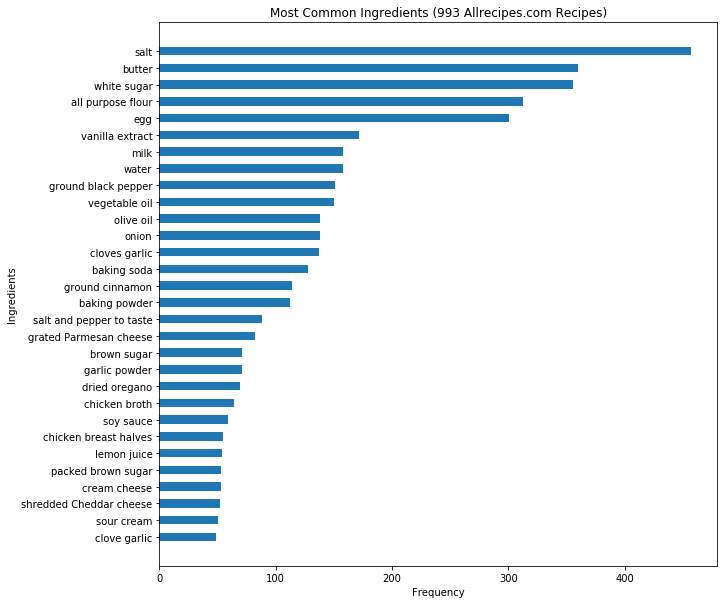

In [203]:
fig, ax = plt.subplots(figsize = (10,10))

n = 30
bar_positions = np.arange(n)
bar_heights = ingredients['edited'].value_counts().head(n)
bar_names = ingredients['edited'].value_counts().head(n).index

ax.barh(bar_positions, bar_heights, 0.5)
ax.set_yticks(bar_positions)
ax.set_yticklabels(bar_names)
ax.set_title('Most Common Ingredients (' + str(recipes.shape[0]) + ' Allrecipes.com Recipes)')
ax.set_ylabel('Ingredients')
ax.set_xlabel('Frequency')
ax.invert_yaxis()
plt.show()

### Analyzing Servings

Each recipe has a listed servings amount.  These are stored as integer values already, so should be simple to visualize.

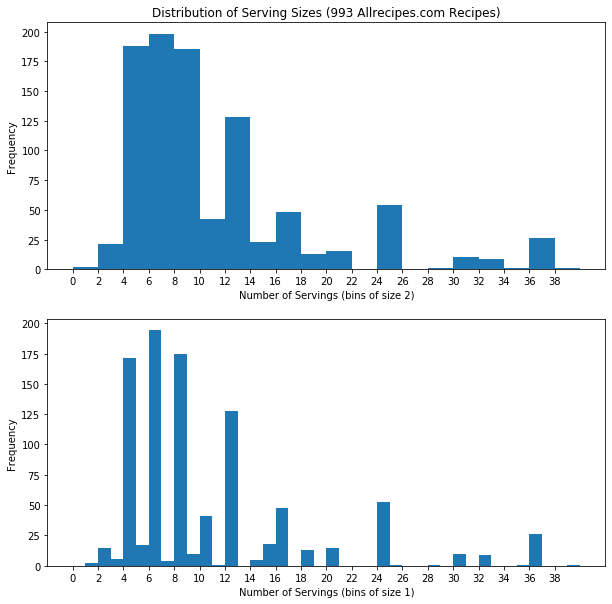

In [233]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

bins = 20
max = 40
tick_positions = max/bins * np.arange(bins)

ax1.hist(recipes['servings'], bins=bins, range=(0,max))
ax1.set_xticks(tick_positions)
ax1.set_xlabel('Number of Servings (bins of size 2)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Serving Sizes (' + str(recipes.shape[0]) + ' Allrecipes.com Recipes)')

ax2.hist(recipes['servings'], bins=max, range=(0,max))
ax2.set_xticks(tick_positions)
ax2.set_xlabel('Number of Servings (bins of size 1)')
ax2.set_ylabel('Frequency')

plt.show()

So, we notice that the number of servings has a skewed right distribution, with the mode at 6 servings.  The most common values are 6, 8, 4, and 12.

### Analyzing Cooking, Prep, and Total Time

All of the scraped recipes have columns for Prep Time, Cook Time, Additional Time, and Total Time.  Some of these values are blank, and all are stored as string objects.  Some strings have units attached and others do not, so we will need to do some cleaning to get them all to numerical values.

In [176]:
time_columns = ['cook_time','prep_time','additional_time','total_time']
recipes[time_columns].head(10)

,cook_time,prep_time,additional_time,total_time
0,20 mins,20 mins,2 hrs,2 hrs 40 mins
1,2 hrs 30 mins,30 mins,15 mins,3 hrs 15 mins
2,10 mins,20 mins,30 mins,1 hr
3,10,10,,25
4,15,5,,20
5,1 hr 5 mins,15 mins,,1 hr 20 mins
6,1 hr,30 mins,,1 hr 30 mins
7,25,20,,45
8,20 mins,15 mins,,35 mins
9,25 mins,15 mins,,40 mins


In [178]:
recipes.dtypes

title              object
servings            int64
cook_time          object
prep_time          object
additional_time    object
total_time         object
ingredients        object
method             object
layout              int64
picture            object
dtype: object